# Movie Reccommender

### Imports

In [93]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from scipy import stats
from ast import literal_eval
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from sklearn.preprocessing import OneHotEncoder, MultiLabelBinarizer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate

import warnings; warnings.simplefilter('ignore')
pd.set_option('display.max_columns', None)

In [94]:
md = pd.read_csv('data/movies_metadata.csv')
md.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,/e64sOI48hQXyru7naBFyssKFxVd.jpg,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [95]:
for i in list(md.columns):
    print(i)

adult
belongs_to_collection
budget
genres
homepage
id
imdb_id
original_language
original_title
overview
popularity
poster_path
production_companies
production_countries
release_date
revenue
runtime
spoken_languages
status
tagline
title
video
vote_average
vote_count


<AxesSubplot:>

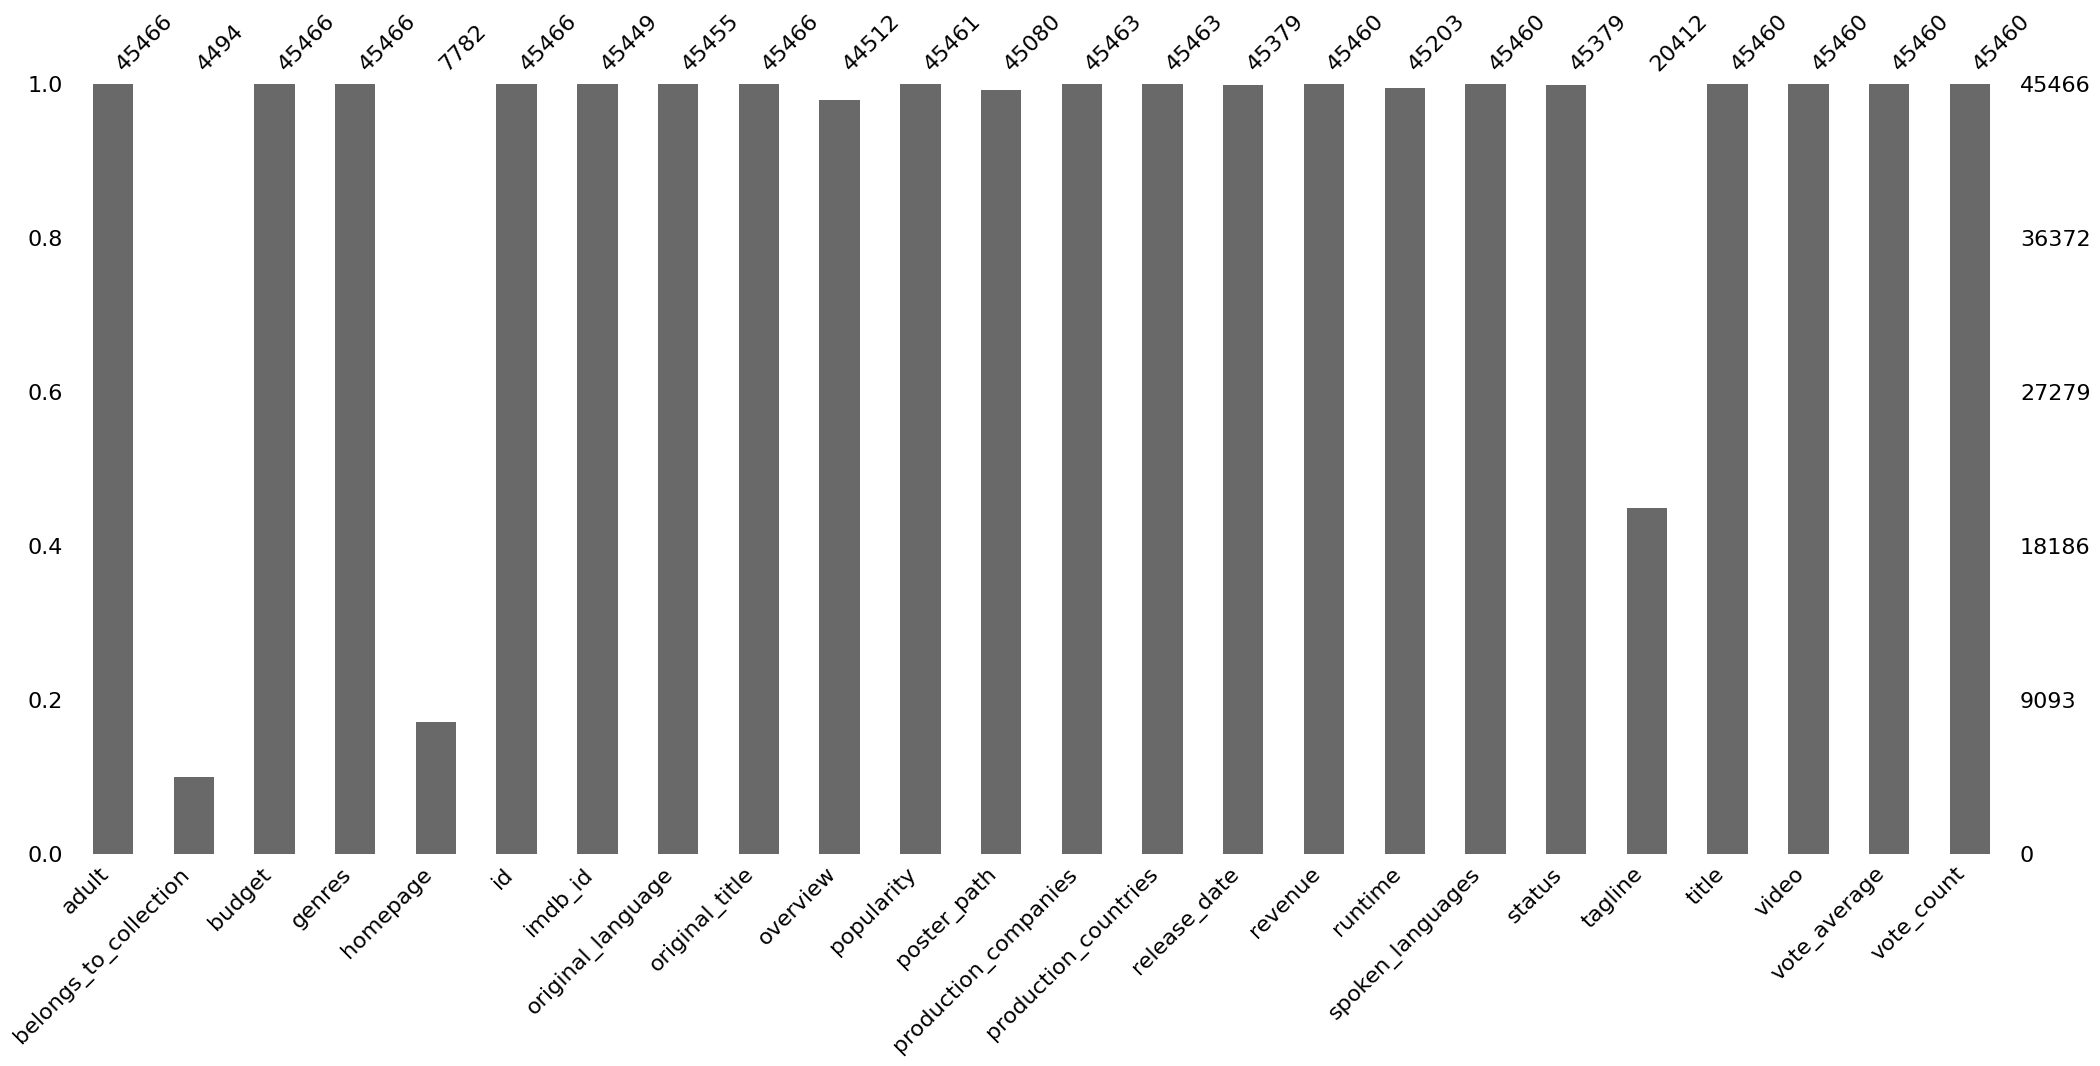

In [96]:
msno.bar(md)

### Cleaning up

Ideas:

- might be a good idea to try and drop really unpopular films, maybe define minimum threshholds for vote_count, budget, runtime?

- for our purposes, we may be able to get rid of certain columns such as status, homepage, tagline?, video

- replace belongs to collection values with numbers: not a collection - 0, trilogy - 3, etc.

In [97]:
md['year'] = pd.to_datetime(md['release_date'], errors='coerce').apply(lambda x: str(x).split('-')[0] if x != np.nan else np.nan)

md['genres'] = md['genres'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])


### Getting Ratings for movies

Weighted Rating (WR) =  (v.R/(v+m))+(m.C/(v+m))
 
where,


- v is the number of votes for the movie
- m is the minimum votes required to be listed in the chart
- R is the average rating of the movie
- C is the mean vote across the whole report

In [98]:
vote_counts = md[md['vote_count'].notnull()]['vote_count'].astype('int')
vote_averages = md[md['vote_average'].notnull()]['vote_average'].astype('int')
C = vote_averages.mean()
m = vote_counts.quantile(0.95)

In [99]:
qualified = md[(md['vote_count'] >= m) & (md['vote_count'].notnull()) & (md['vote_average'].notnull())][['title', 'year', 'vote_count', 'vote_average', 'popularity', 'genres']]
qualified['vote_count'] = qualified['vote_count'].astype('int')
qualified['vote_average'] = qualified['vote_average'].astype('int')
qualified.shape

(2274, 6)

In [100]:
def weighted_rating(x):
    v = x['vote_count']
    R = x['vote_average']
    return (v/(v+m) * R) + (m/(m+v) * C)

In [101]:
qualified['wr'] = qualified.apply(weighted_rating, axis=1)

In [102]:
qualified.sort_values('wr', ascending=False).head(10)

,title,year,vote_count,vote_average,popularity,genres,wr
15480,Inception,2010,14075,8,29.108149,"[Action, Thriller, Science Fiction, Mystery, A...",7.917588
12481,The Dark Knight,2008,12269,8,123.167259,"[Drama, Action, Crime, Thriller]",7.905871
22879,Interstellar,2014,11187,8,32.213481,"[Adventure, Drama, Science Fiction]",7.897107
2843,Fight Club,1999,9678,8,63.869599,[Drama],7.881753
4863,The Lord of the Rings: The Fellowship of the Ring,2001,8892,8,32.070725,"[Adventure, Fantasy, Action]",7.871787
292,Pulp Fiction,1994,8670,8,140.950236,"[Thriller, Crime]",7.868660
314,The Shawshank Redemption,1994,8358,8,51.645403,"[Drama, Crime]",7.864000
7000,The Lord of the Rings: The Return of the King,2003,8226,8,29.324358,"[Adventure, Fantasy, Action]",7.861927
351,Forrest Gump,1994,8147,8,48.307194,"[Comedy, Drama, Romance]",7.860656
5814,The Lord of the Rings: The Two Towers,2002,7641,8,29.423537,"[Adventure, Fantasy, Action]",7.851924


<h1>Pipeline</h1>

In [103]:
def drop_columns(df):
    df.drop(['homepage', 'poster_path', 'production_companies', 'production_countries', 'status', 'tagline', 'video'], axis=1, inplace=True)
    return df

<AxesSubplot:>

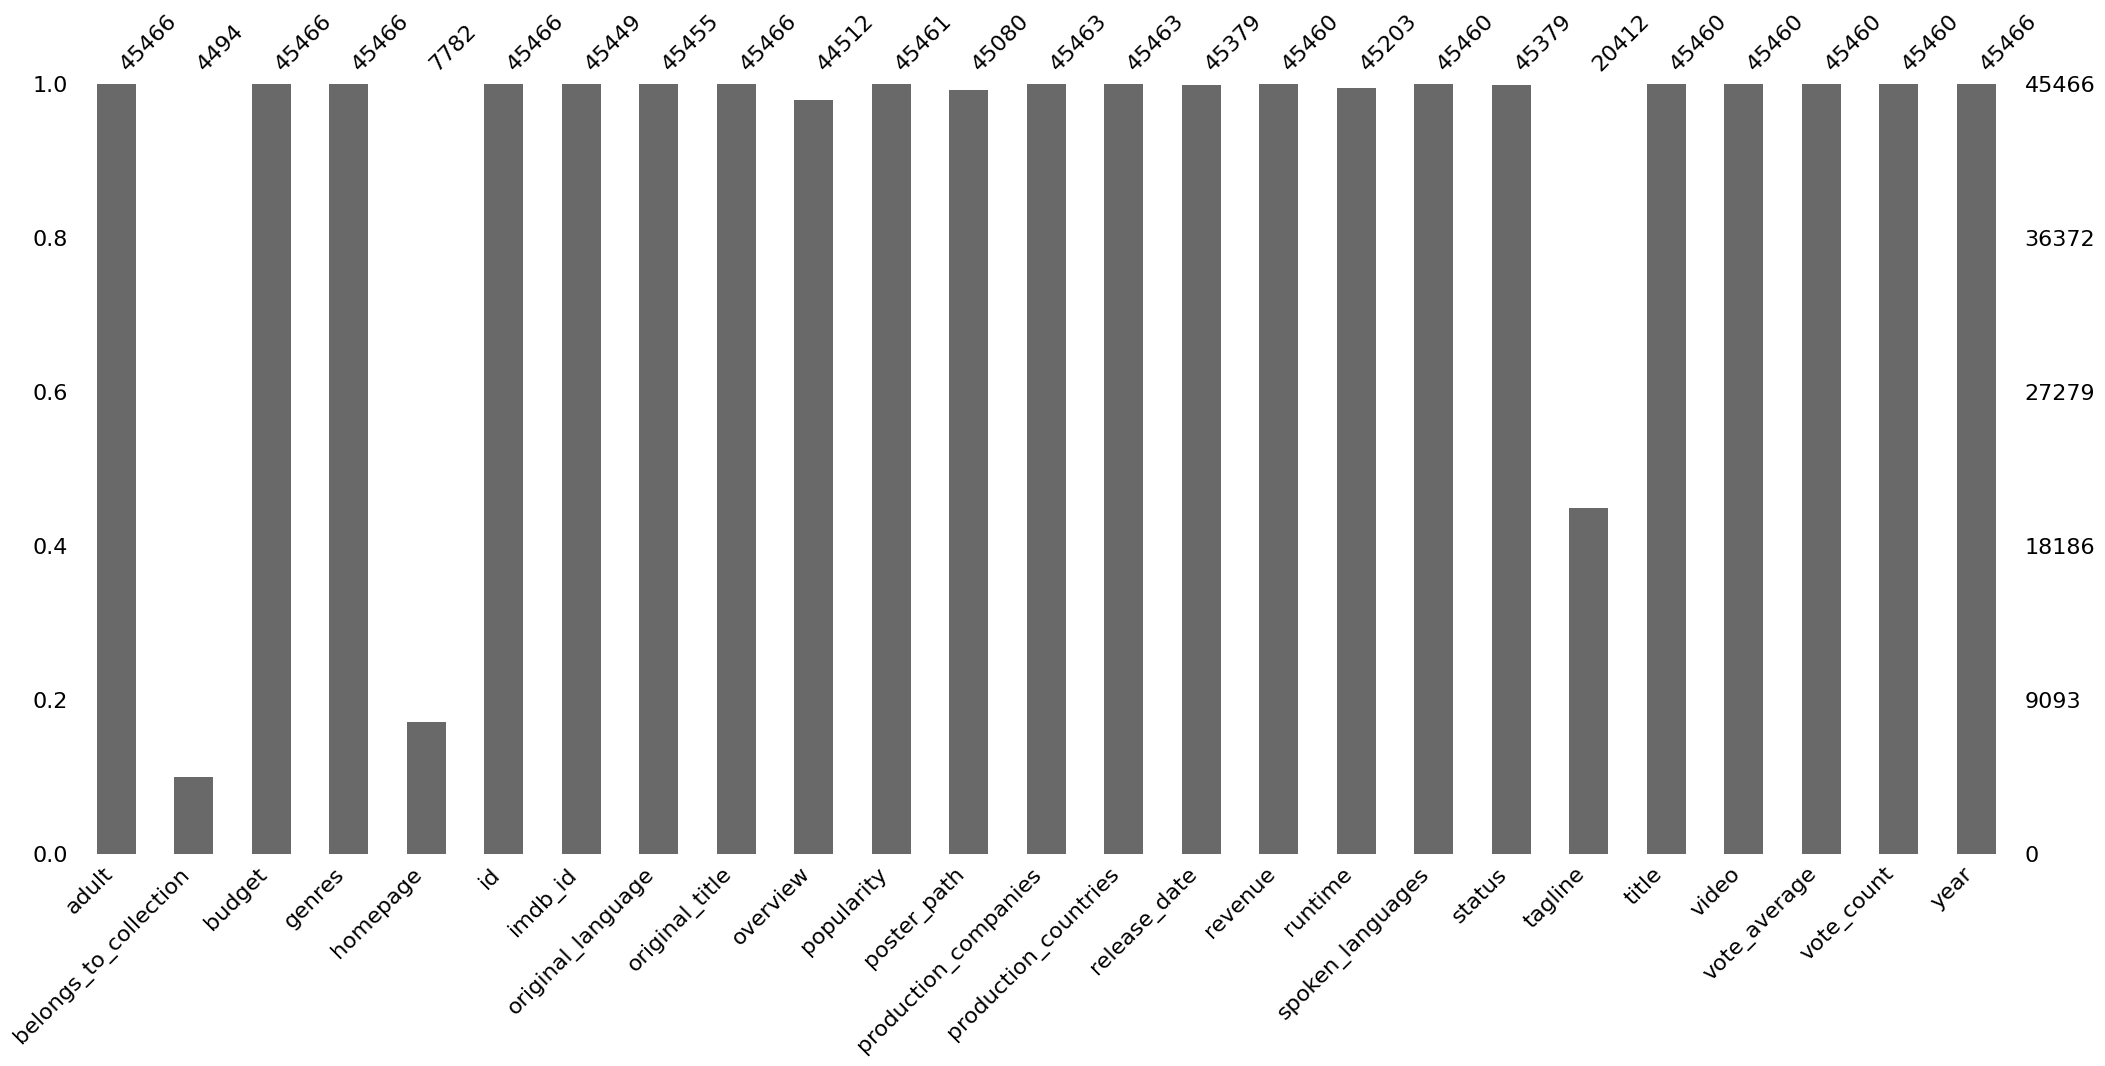

In [104]:
(md).columns
msno.bar(md)

In [105]:
def drop_na(df):
    df.dropna(axis =0, subset=['adult', 'budget', 'genres', 'id', 'imdb_id',
       'original_language', 'original_title', 'overview', 'popularity',
       'release_date', 'revenue', 'runtime', 'spoken_languages', 'title',
       'vote_average', 'vote_count', 'year'], inplace = True)

In [106]:
def one_hot_genres(df):
    mlb = MultiLabelBinarizer()
    encoded_data = mlb.fit_transform(df['genres'])
    encoded_df = pd.DataFrame(encoded_data, columns=mlb.classes_)

    # Concatenate the encoded DataFrame with the original DataFrame along columns (axis=1)
    df = pd.concat([df, encoded_df], axis=1)

    # Drop the original 'genres' column
    df.drop('genres', axis=1, inplace=True)

    return df

In [107]:
def extract_name(string):
    if isinstance(string, str):  # Check if the value is a string
        start = string.find("'name': '") + len("'name': '")
        end = string.find("'", start)
        if start != -1 and end != -1:
            return string[start:end]
    return None

def process_collection(df):
    df['collection_name'] = df['belongs_to_collection'].apply(extract_name)
    collection_counts = Counter(df['collection_name'].dropna())
    df['series_count'] = df.apply(lambda row: collection_counts.get(row['collection_name'], 0), axis=1)
    return df

In [108]:
md.pipe(drop_columns)
md.pipe(drop_na)
md.pipe(one_hot_genres)
md.pipe(extract_name)
md.pipe(process_collection)
md.drop(['belongs_to_collection'], axis=1, inplace=True)
md.head()

,adult,budget,genres,id,imdb_id,original_language,original_title,overview,popularity,release_date,revenue,runtime,spoken_languages,title,vote_average,vote_count,year,collection_name,series_count
0,False,30000000,"[Animation, Comedy, Family]",862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Toy Story,7.7,5415.0,1995,Toy Story Collection,3
1,False,65000000,"[Adventure, Fantasy, Family]",8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Jumanji,6.9,2413.0,1995,None,0
2,False,0,"[Romance, Comedy]",15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Grumpier Old Men,6.5,92.0,1995,Grumpy Old Men Collection,2
3,False,16000000,"[Comedy, Drama, Romance]",31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Waiting to Exhale,6.1,34.0,1995,None,0
4,False,0,[Comedy],11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Father of the Bride Part II,5.7,173.0,1995,Father of the Bride Collection,2


<AxesSubplot:>

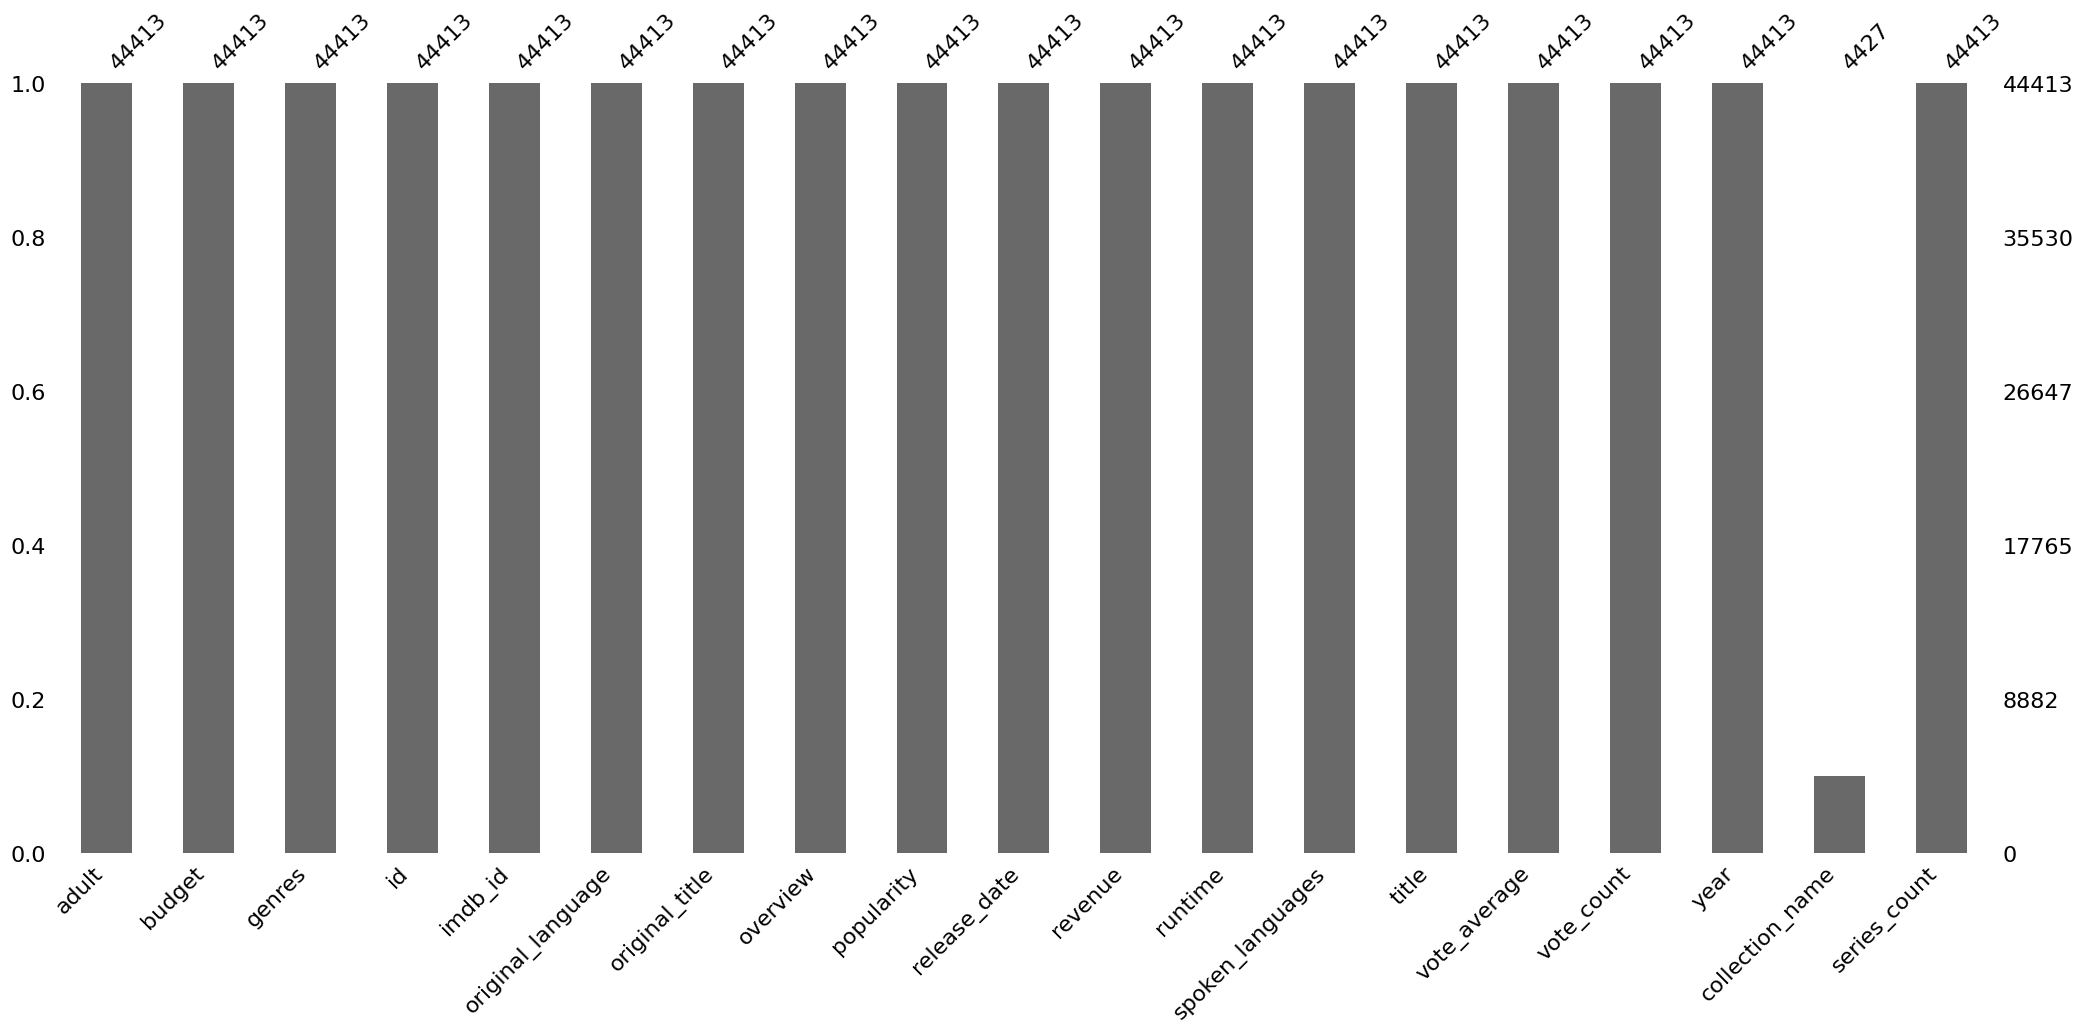

In [109]:
msno.bar(md)

In [110]:
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(md['overview'])
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
md = md.reset_index()
titles = md['title']
indices = pd.Series(md.index, index=md['title'])

MemoryError: Unable to allocate 14.7 GiB for an array with shape (44413, 44413) and data type float64

In [ ]:
def get_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:31]
    movie_indices = [i[0] for i in sim_scores]
    return titles.iloc[movie_indices]